In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_aer

In [ ]:
import numpy as np
import pandas as pd
import random as rn
from math import pi,sqrt,floor
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import *
from qiskit_aer import AerSimulator
from qiskit.circuit.library import MCMT, XGate

## Some useful functions

In [ ]:
# Function for plotting the quantum circuit
def qplot(qc):
    return qc.draw('mpl', scale=0.8, initial_state= True, fold=-1)

def latex(quantum_state):
  return Statevector(quantum_state).draw('latex')

## Function for converting Qiskit result to hidden string

In [ ]:
def convert_string(counts: dict):
  counts_list = list(counts.keys())[0]
  counts_reversed = counts_list[::-1]
  return counts_reversed[:-1]

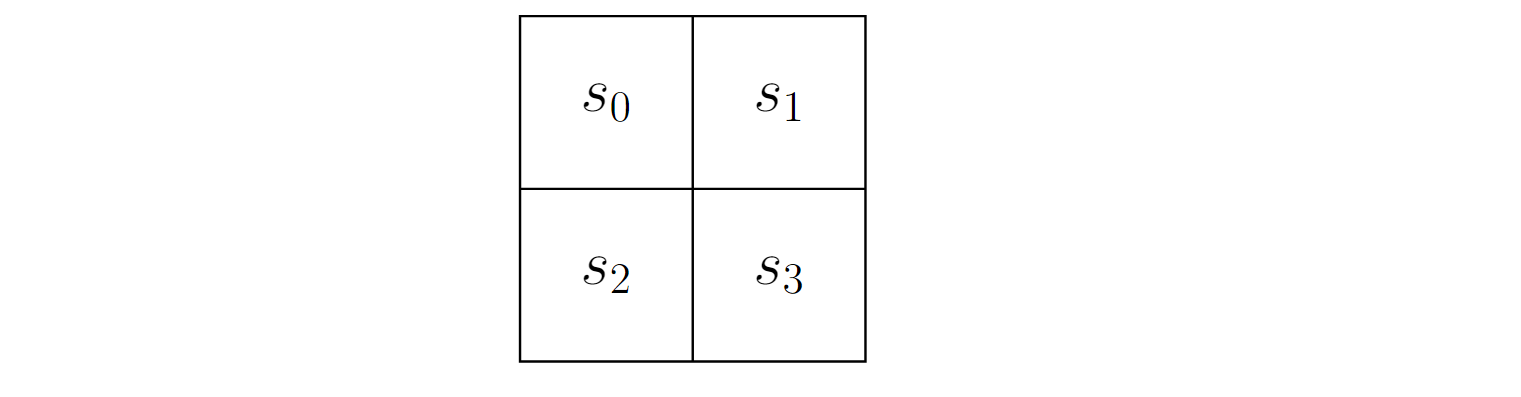

We have for clauses for this small Sudoku
1. $1^{st}$ clause: $s_0 \neq s_1 $
2. $2^{nd}$ clause: $s_0 \neq s_2 $    
3. $3^{rd}$ clause: $s_1 \neq s_3 $
4. $4^{th}$ clause: $s_2 \neq s_3 $        


In [ ]:
clauses_list = [(0,1), (0,2), (1,3), (2,3)]

we can easily build a quantum circuit as an oracle for this problem

In [ ]:
num_qubits = 4
N = num_qubits**2

In [ ]:
# Number of desired states
d = 2

# What should be the desired answers for this Sudoku problem?
According to these clauses, states '1001' and '0110' are two possible asnwers. Thus we are doing a search over _d_ files by Grover search algorithm.

# Create the Oracle

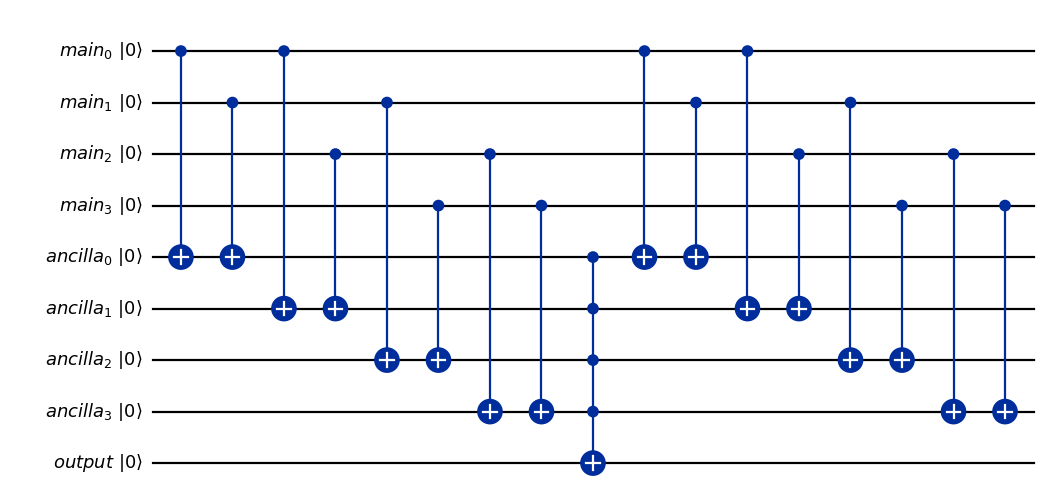

In [ ]:
qreg = QuantumRegister(num_qubits, name = 'main') # a quantum register with exactly 4 qubits
areg = QuantumRegister(num_qubits, name = 'ancilla')
outreg = QuantumRegister(1, name = 'output')

oracle = QuantumCircuit(qreg, areg, outreg)

for index, pair in enumerate(clauses_list):
  oracle.cx(pair[0],num_qubits+index)
  oracle.cx(pair[1],num_qubits+index)

oracle.mcx(areg, outreg)

for index, pair in enumerate(clauses_list):
  oracle.cx(pair[0],num_qubits+index)
  oracle.cx(pair[1],num_qubits+index)

oracle.to_gate()
oracle.name = "Sudoku Oracle"

qplot(oracle)

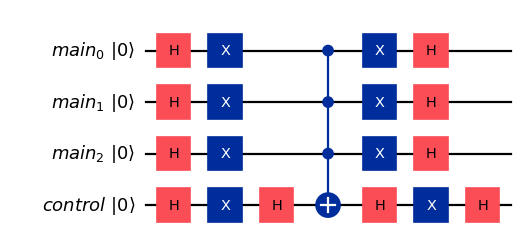

In [ ]:
qreg = QuantumRegister(num_qubits-1, name = 'main') # a quantum register with exactly 4 qubits
control = QuantumRegister(1, name = 'control')
all_reg = qreg[:] + control[:]

diffuser = QuantumCircuit(qreg, control)
diffuser.h(all_reg)
# Reflector part
diffuser.x(all_reg)
diffuser.h(control)
diffuser.mcx(qreg, control)
diffuser.h(control)
diffuser.x(all_reg)
######################## end of Reflector part
diffuser.h(all_reg)
diffuser.to_gate()
diffuser.name = "Diffuser"

qplot(diffuser)

# Create the Grover Operator

# Running the algorithm and finding the Sudoku answer

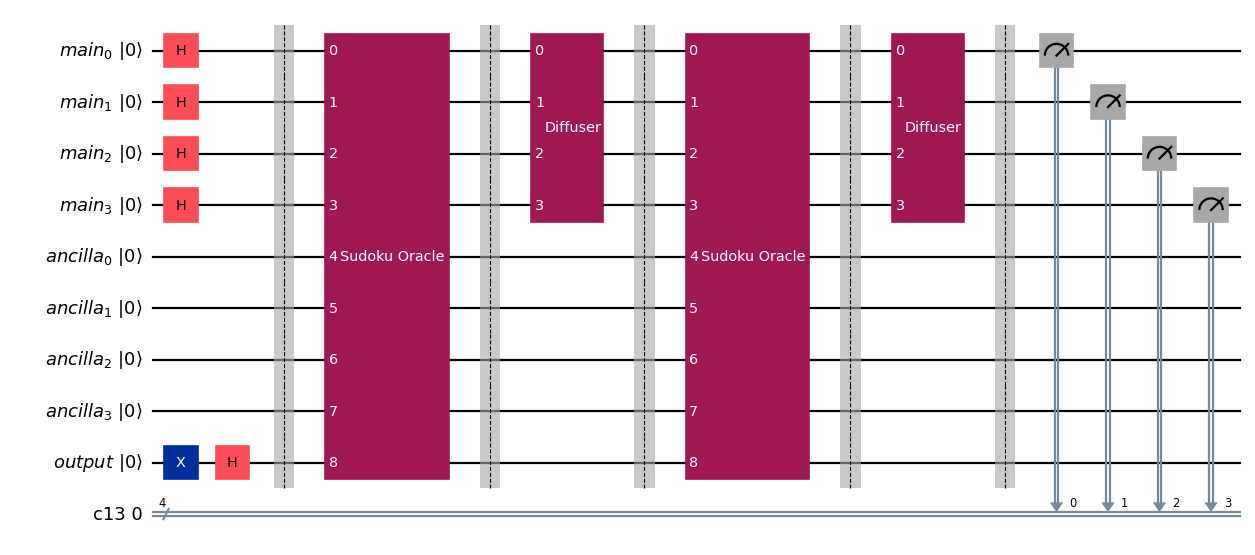

In [ ]:
qreg = QuantumRegister(num_qubits, name = 'main') # a quantum register with exactly 4 qubits
areg = QuantumRegister(num_qubits, name = 'ancilla')
outreg = QuantumRegister(1, name = 'output')
c = ClassicalRegister(num_qubits)

all_qubits = qreg[:] + areg[:] + outreg[:]

cirq = QuantumCircuit(qreg, areg, outreg, c)

# Building an uniform superposition of main qubits and prepare the output qubit in the state |->
cirq.h(qreg)
cirq.x(outreg)
cirq.h(outreg)
cirq.barrier()


# Iteration of the Grover search

iter = floor((sqrt(N/d)*(pi/4))) # Number of iteration that we need
# iterate the circuit for iter times
for _ in range(iter):
  # Applying the Sudoku oracle
  cirq.append(oracle, all_qubits)
  cirq.barrier()
  # Applying the diffuser
  cirq.append(diffuser, qreg)
  cirq.barrier()

cirq.measure(qreg, c)


qplot(cirq)

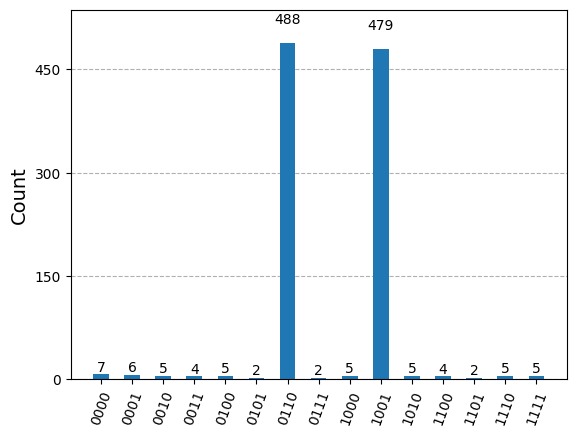

In [ ]:
backend = AerSimulator()
job = backend.run(transpile(cirq, backend), shots = 1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)